In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
from datetime import datetime
import warnings
from sklearn.metrics import confusion_matrix,roc_curve,auc,cohen_kappa_score
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import math
import random
from scipy.stats import t
import scipy.stats as st
import numpy as np
import collections
from numbers import Number
from __future__ import division
warnings.filterwarnings("ignore")
rcParams['figure.figsize'] = 15, 6
use_colours = {0: "blue", 1: "red"}

/home/bharath/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = pd.rolling_mean(timeseries, window=12)
    rolstd = pd.rolling_std(timeseries, window=12)

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

In [33]:
df = pd.read_csv("/home/bharath/full_datasets/fact_trade/fact_trade_monthly_0205.csv")

In [34]:
df.head()

,id,yearmonth,flow_desc,reporter,partner,unit_weight,product_code,product_desc,trade_weight,trade_value,source
0,48491112,200712,export,UNITED STATES,CHINA TAIWAN,kg,205000000,H/A/M/H-MT/FCF,0.0,0.0,usda_trade_flow_pig
1,48491111,200711,export,UNITED STATES,CHINA TAIWAN,kg,205000000,H/A/M/H-MT/FCF,0.0,0.0,usda_trade_flow_pig
2,48491110,200710,export,UNITED STATES,CHINA TAIWAN,kg,205000000,H/A/M/H-MT/FCF,0.0,0.0,usda_trade_flow_pig
3,48491109,200709,export,UNITED STATES,CHINA TAIWAN,kg,205000000,H/A/M/H-MT/FCF,0.0,0.0,usda_trade_flow_pig
4,48491108,200708,export,UNITED STATES,CHINA TAIWAN,kg,205000000,H/A/M/H-MT/FCF,0.0,0.0,usda_trade_flow_pig


In [35]:
df.yearmonth = df.yearmonth.astype(str)

In [36]:
df["yearmonth"] = df.yearmonth.apply(lambda dates: datetime.strptime(dates, '%Y%m').strftime('%m/%Y'))

In [37]:
df['yearmonth'] = pd.to_datetime(df['yearmonth'])


In [38]:
df['Year'] = df['yearmonth'].dt.year

In [32]:
#df = df.set_index("yearmonth")


In [39]:
df.shape

(19629, 12)

This dataset contains multiple products hence the first task is to separate it and then run anomaly detection over each category of product

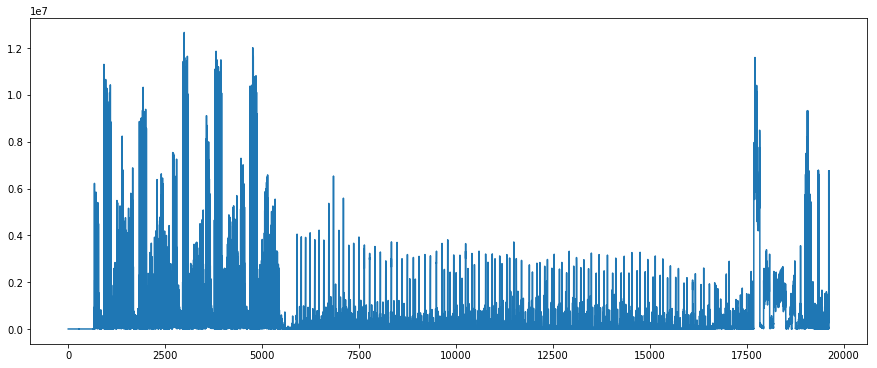

In [42]:
ts = df["trade_value"]
plt.plot(ts)

In [45]:
df_new = df

In [44]:
#test_stationarity(ts)

In [46]:
def movingaverage(index,interval, window_size):
    window= np.ones(int(window_size))/float(window_size)
    y_av = np.convolve(interval, window, 'same')
    plt.plot(index, y_av,"r")
    plt.plot(index, y_av,"r")
    plt.grid(True)
    plt.show()

    std = np.std(y_av)
    events= []
    ind = []
    for i in range(len(interval)):
        if interval[i] > y_av[i]+std:
            events.append(interval[i])
    return events


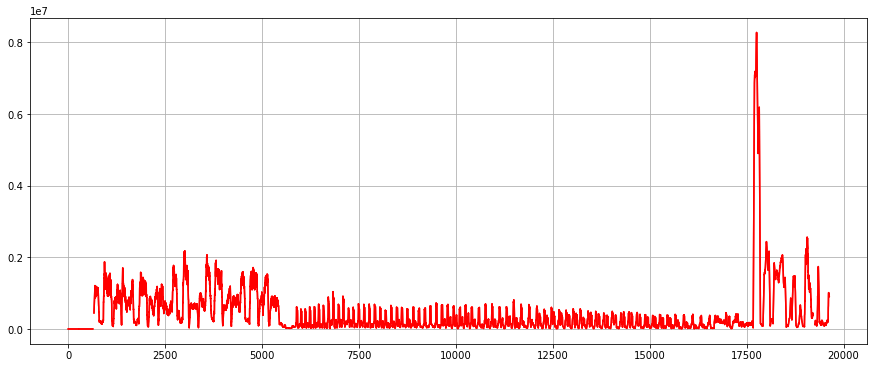

In [47]:
events = movingaverage(df_new.index.values,df_new.trade_value,30)

In [48]:
len(events)

0

In [49]:
df_new = df_new.set_index("yearmonth")

In [51]:
df_new.trade_value = df_new.trade_value.fillna(np.mean(df_new.trade_value))

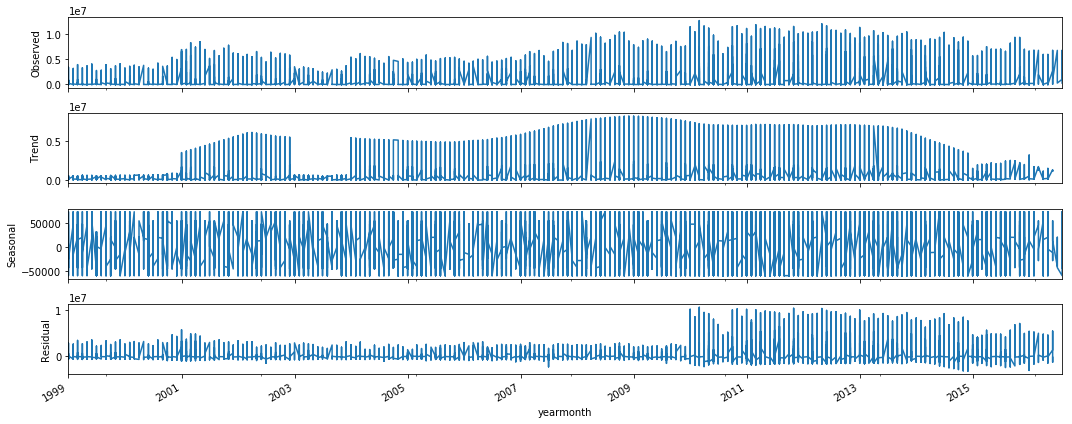

In [52]:
res = sm.tsa.seasonal_decompose(df_new["trade_value"],freq=30)
resplot = res.plot()

In [53]:
random = res.resid
min_res = np.mean(random) - 3*np.std(random)
max_res = np.mean(random) + 3*np.std(random)

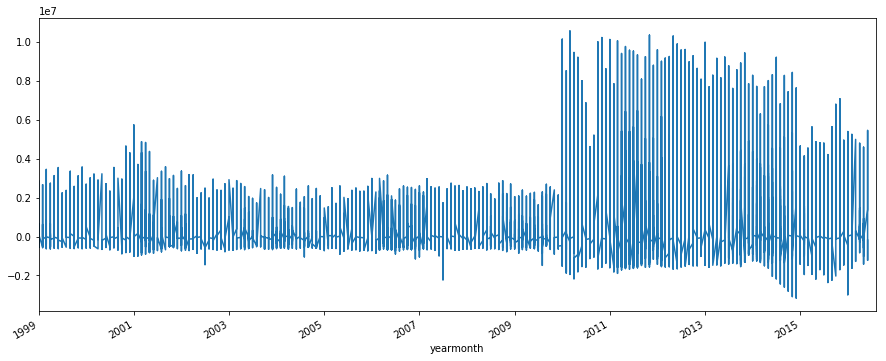

In [54]:
random.plot()

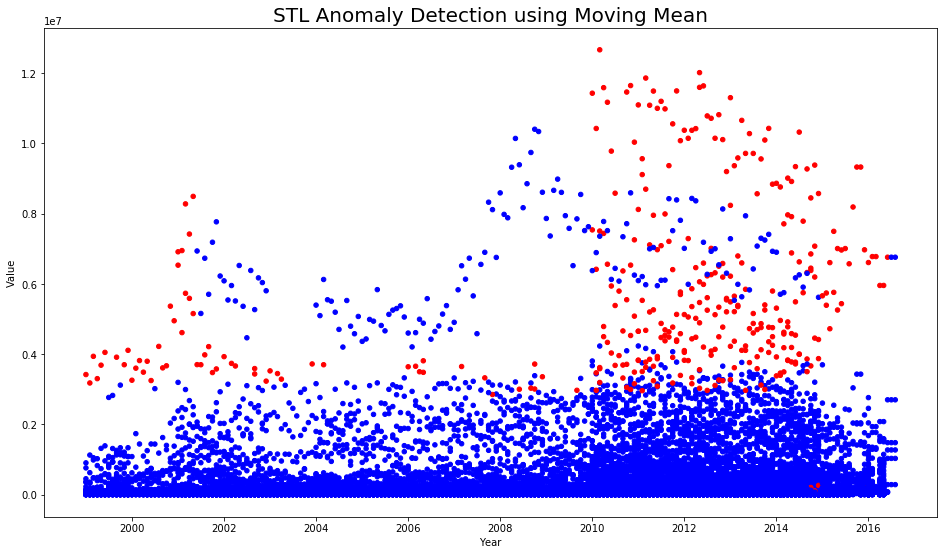

In [56]:
anomaly = []
for i in random:
    if i > max_res or i < min_res:
        anomaly.append(True)
    else:
        anomaly.append(False)

plt.figure(figsize=(16,9))
plt.scatter(df_new.index, df_new.trade_value, c=[use_colours[x] for x in anomaly], s=20)
plt.xlabel('Year')
plt.ylabel('Value')
plt.title("STL Anomaly Detection using Moving Mean", fontsize="20")

In [57]:
def running_median_numpy(seq,window_size):
    data = np.array(seq, dtype=float)
    result = []
    for i in range(1, window_size):
        window = data[:i]
        result.append(np.median(window))
    for i in range(len(data)-window_size+1):
        window = data[i:i+window_size]
        result.append(np.median(window))
    return result

In [58]:
random_med = running_median_numpy(df_new.trade_value.values,30)

In [59]:
random_med = np.array(random_med)

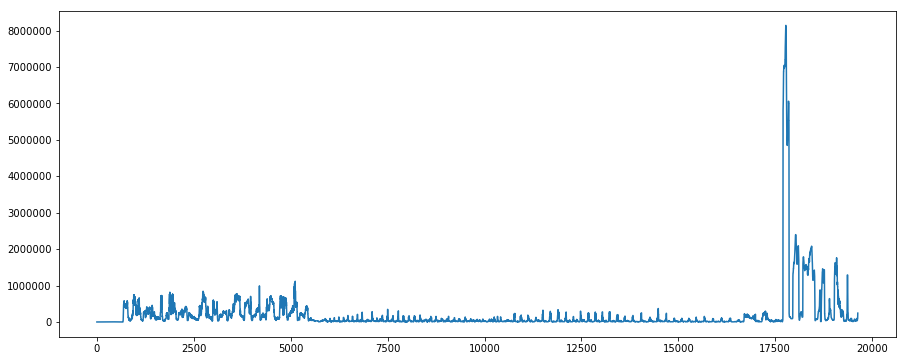

In [60]:
plt.plot(random_med)

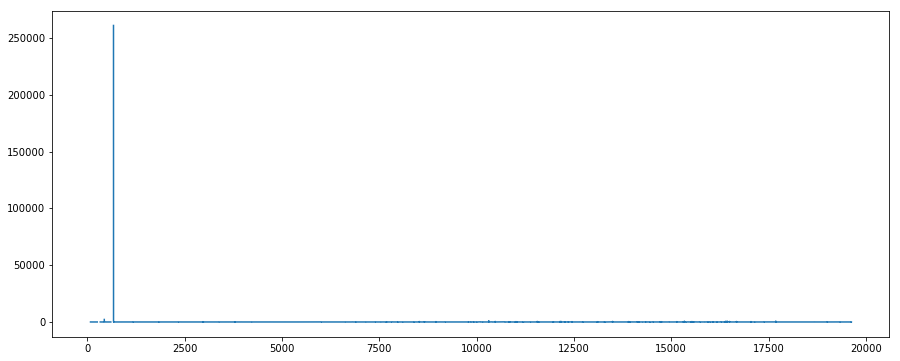

In [61]:
detrend_median = df_new.trade_value.values / random_med
plt.plot(detrend_median)

In [62]:
seasonal = np.mean(detrend_median)

In [63]:
random = df_new.trade_value.values / (random_med * seasonal)

In [64]:
detrend_median_wo_anom = running_median_numpy(random,3)

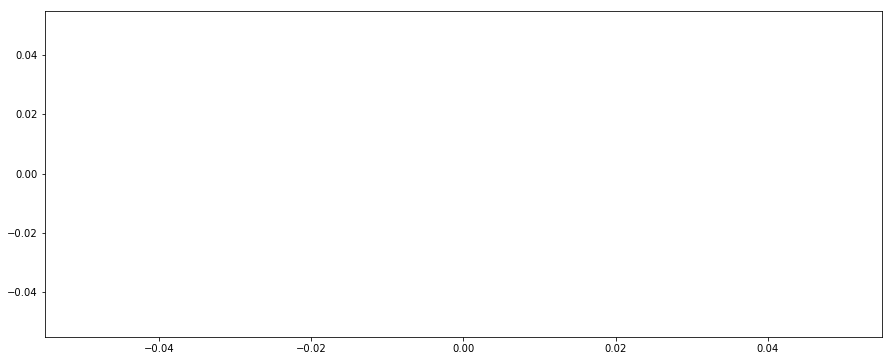

In [65]:
plt.plot(detrend_median_wo_anom)

In [66]:
min_res_med = np.mean(detrend_median_wo_anom) - 3*np.std(detrend_median_wo_anom)
max_res_med = np.mean(detrend_median_wo_anom) + 3*np.std(detrend_median_wo_anom)

In [67]:
df_new = df_new.reset_index(drop=True)

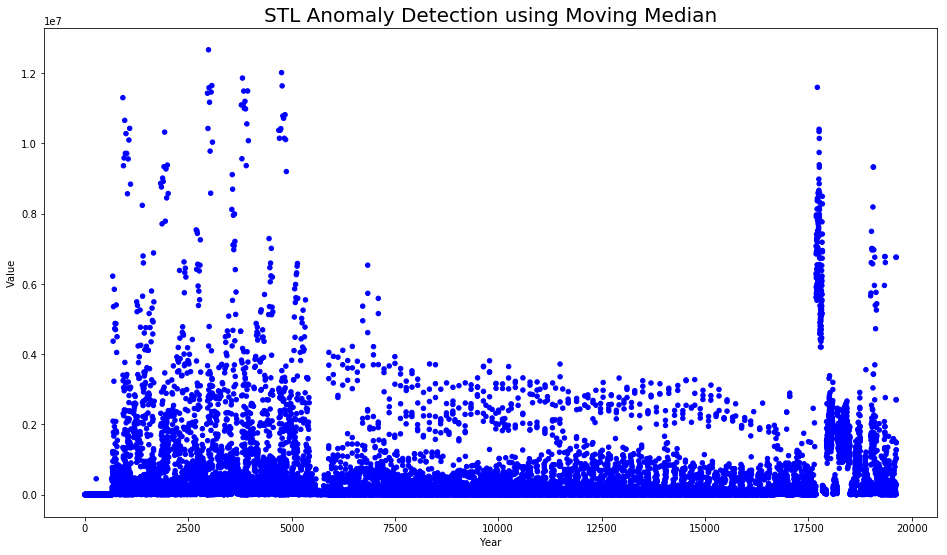

In [68]:
anomaly = []
for i in random:
    if i > max_res_med or i < min_res_med:
        anomaly.append(True)
    else:
        anomaly.append(False)

use_colours = {0: "blue", 1: "red"}
#ax.scatter(a,b,c,c=[use_colours[x[0]] for x in df["Outlier"]],s=50)

plt.figure(figsize=(16,9))
plt.scatter(df_new.index, df_new.trade_value, c=[use_colours[x] for x in anomaly], s=20)
plt.xlabel('Year')
plt.ylabel('Value')
plt.title("STL Anomaly Detection using Moving Median", fontsize="20")

Since the p value is less than than the 5 % and 10 % critical value and very close to the 1 % level, the null hypothesis can be 
rejected and it can be concluded that the signal is stationary

Label Encoding

In [69]:
df_new.head()

,id,flow_desc,reporter,partner,unit_weight,product_code,product_desc,trade_weight,trade_value,source,Year
0,48491112,export,UNITED STATES,CHINA TAIWAN,kg,205000000,H/A/M/H-MT/FCF,0.0,0.0,usda_trade_flow_pig,2007
1,48491111,export,UNITED STATES,CHINA TAIWAN,kg,205000000,H/A/M/H-MT/FCF,0.0,0.0,usda_trade_flow_pig,2007
2,48491110,export,UNITED STATES,CHINA TAIWAN,kg,205000000,H/A/M/H-MT/FCF,0.0,0.0,usda_trade_flow_pig,2007
3,48491109,export,UNITED STATES,CHINA TAIWAN,kg,205000000,H/A/M/H-MT/FCF,0.0,0.0,usda_trade_flow_pig,2007
4,48491108,export,UNITED STATES,CHINA TAIWAN,kg,205000000,H/A/M/H-MT/FCF,0.0,0.0,usda_trade_flow_pig,2007


In [70]:
df_new_corr = df_new.corr()

In [71]:
df_new_corr

,id,product_code,trade_weight,trade_value,Year
id,1.000000,0.138094,-0.023018,-0.014943,0.028026
product_code,0.138094,1.000000,-0.241413,-0.250566,-0.002231
trade_weight,-0.023018,-0.241413,1.000000,0.904838,0.043289
trade_value,-0.014943,-0.250566,0.904838,1.000000,0.075675
Year,0.028026,-0.002231,0.043289,0.075675,1.000000


Imputation and building the upper and lower bounds for building the Anomaly threshold

In [72]:
#df_new.trade_value = df_new.trade_value.fillna(np.mean(df_new.trade_value))
df_new = df_new.dropna()
df_new = df_new.reset_index(drop=True)
sd = np.std(df_new["trade_value"])
mean = np.mean(df_new["trade_value"])
# Upper Bound
X_upper = mean + sd*4
# Lower Bound
X_lower = mean - sd*4

Generating the outliers for evaluation

In [73]:
rng = np.random.RandomState(42)

# Generate some abnormal novel observations
X_outliers_1 = rng.uniform(low=X_upper*0.9, high=X_upper*2, size=(50, 1))
X_outliers_2 = rng.uniform(low=-X_lower*1.5, high=-X_lower*2, size=(50, 1))

In [74]:
Outliers = []
Outliers.extend(X_outliers_1)
Outliers.extend(X_outliers_2)

Creating the outlier Class and inserting the anomalous data in the dataset

In [75]:
df_new["Actual"] = False

In [76]:
idx = df_new.index
for i in Outliers:
    loc = np.random.randint(0, len(df_new))
    df_new.loc[loc,"trade_value"] = i
    df_new.loc[loc,"Actual"] = True

In [77]:
df_new.head()

,id,flow_desc,reporter,partner,unit_weight,product_code,product_desc,trade_weight,trade_value,source,Year,Actual
0,48491112,export,UNITED STATES,CHINA TAIWAN,kg,205000000,H/A/M/H-MT/FCF,0.0,0.0,usda_trade_flow_pig,2007,False
1,48491111,export,UNITED STATES,CHINA TAIWAN,kg,205000000,H/A/M/H-MT/FCF,0.0,0.0,usda_trade_flow_pig,2007,False
2,48491110,export,UNITED STATES,CHINA TAIWAN,kg,205000000,H/A/M/H-MT/FCF,0.0,0.0,usda_trade_flow_pig,2007,False
3,48491109,export,UNITED STATES,CHINA TAIWAN,kg,205000000,H/A/M/H-MT/FCF,0.0,0.0,usda_trade_flow_pig,2007,False
4,48491108,export,UNITED STATES,CHINA TAIWAN,kg,205000000,H/A/M/H-MT/FCF,0.0,0.0,usda_trade_flow_pig,2007,False


In [78]:
df_new["reporter"] = df["reporter"].astype('category').cat.codes

Extracting the features for Boxplot visualization

In [79]:
from sklearn import preprocessing
df_new = df_new.dropna()
df_new_2 = df_new[["trade_value"]]
#df_new = df["price"]
min_max_scaler = preprocessing.MinMaxScaler()
df_scaled = min_max_scaler.fit_transform(df_new_2)
df_scaled = pd.DataFrame(df_scaled)
df_scaled = df_scaled.astype('float32')

In [80]:
len(df_scaled)

19485

Resizing the array for training autoencoder neural network 

In [81]:
array = np.array(df_scaled)
row,column = array.shape
array = array.reshape((1,row,column))

In [82]:
array.shape

(1, 19485, 1)

In [83]:
from keras.layers import Input, Dense
from keras.models import Model

# this is the size of our encoded representations
encoding_dim = column  # 80 floats -> compression of factor 0.8, assuming the input is 100 floats

# this is our input placeholder
input = Input(shape=(row,column))
# "encoded" is the encoded representation of the input
encoded = Dense(encoding_dim, activation='relu')(input)
# "decoded" is the lossy reconstruction of the input
decoded = Dense(column, activation='sigmoid')(encoded)
#rps an input to its reconstruction
autoencoder = Model(inputs=input, outputs=decoded)
encoder = Model(inputs=input, outputs=encoded)

Using TensorFlow backend.


In [84]:

# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=array.shape[1:])
# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# create the decoder model
decoder = Model(inputs=encoded_input, outputs=decoder_layer(encoded_input))
autoencoder.compile(optimizer='adadelta', loss='mse')

In [85]:
# Just compute the distance before learning (show be very bad !)
    
test_encode = encoder.predict(array)
test_decode = decoder.predict(test_encode)
test_encode = test_encode.reshape((row,column))
test_decode = test_decode.reshape((row,column))
test_array = array.reshape((row,column))
naivedist = np.zeros(len(df_scaled.values))
for i, x in enumerate(array):
    naivedist[i] = np.linalg.norm(x-test_decode[i]) 

In [86]:
df_new["naivedist"] = naivedist

In [87]:
autoencoder.fit(array, array,
                epochs=2500,
                batch_size=100,
                shuffle=True,
                verbose=0)

In [88]:
encoded = encoder.predict(array)
decoded = decoder.predict(encoded)

In [89]:
encoded = encoded.reshape((row,column))
decoded = decoded.reshape((row,column))
array = array.reshape((row,column))


In [90]:
dist = np.zeros(len(df_scaled.values))
for i, x in enumerate(array):
    dist[i] = np.linalg.norm(x-decoded[i]) 

In [91]:
df_new["dist"] = dist

In [92]:
def mad_based_outlier(points, thresh=4):
    """
    Returns a boolean array with True if points are outliers and False 
    otherwise.

    Parameters:
    -----------
        points : An numobservations by numdimensions array of observations
        thresh : The modified z-score to use as a threshold. Observations with
            a modified z-score (based on the median absolute deviation) greater
            than this value will be classified as outliers.

    Returns:
    --------
        mask : A numobservations-length boolean array.

    References:
    ----------
        Boris Iglewicz and David Hoaglin (1993), "Volume 16: How to Detect and
        Handle Outliers", The ASQC Basic References in Quality Control:
        Statistical Techniques, Edward F. Mykytka, Ph.D8., Editor.
    """
    if len(points.shape) == 1:
        points = points[:,None]
    median = np.median(points, axis=0)
    diff = np.sum((points - median)**2, axis=-1)
    diff = np.sqrt(diff)
    med_abs_deviation = np.median(diff)

    modified_z_score = 0.6745 * diff / med_abs_deviation
    return modified_z_score > thresh

def doubleMADsfromMedian(y,thresh=4):
    # warning: this function does not check for NAs
    # nor does it address issues when 
    # more than 50% of your data have identical values
    m = np.median(y)
    abs_dev = np.abs(y - m)
    left_mad = np.median(abs_dev[y <= m])
    right_mad = np.median(abs_dev[y >= m])
    y_mad = left_mad * np.ones(len(y))
    y_mad[y > m] = right_mad
    modified_z_score = 0.6745 * abs_dev / y_mad
    modified_z_score[y == m] = 0
    return modified_z_score > thresh

def percentile_based_outlier(data, threshold=99):
    diff = (100 - threshold) / 2.0
    minval, maxval = np.percentile(data, [diff, 100 - diff])
    return (data < minval) | (data > maxval)

# Model for stationary time series
def anomaly_detector1(feature,Z=3):
    results = []
    X= np.sort(feature)
    X_mean = np.mean(X)
    X_std = np.std(X)
    X_upper = X_mean + X_std*Z
    X_lower = X_mean - X_std*Z
    for i in feature:
        if X_upper < i or X_lower > i:
            results.append(True)
        else:
            results.append(False)
    return results


In [93]:
results_mad_AE = mad_based_outlier(dist)
results_mad_Normal = mad_based_outlier(df_new.trade_value)
results_per = percentile_based_outlier(df_new.trade_value)
results_per_AE = percentile_based_outlier(dist)
results_doublemad_AE = doubleMADsfromMedian(dist)
results_doublemad_Normal = doubleMADsfromMedian(df_new.trade_value)
results_AD = anomaly_detector1(df_new.trade_value)
results_AD_AE = anomaly_detector1(dist)

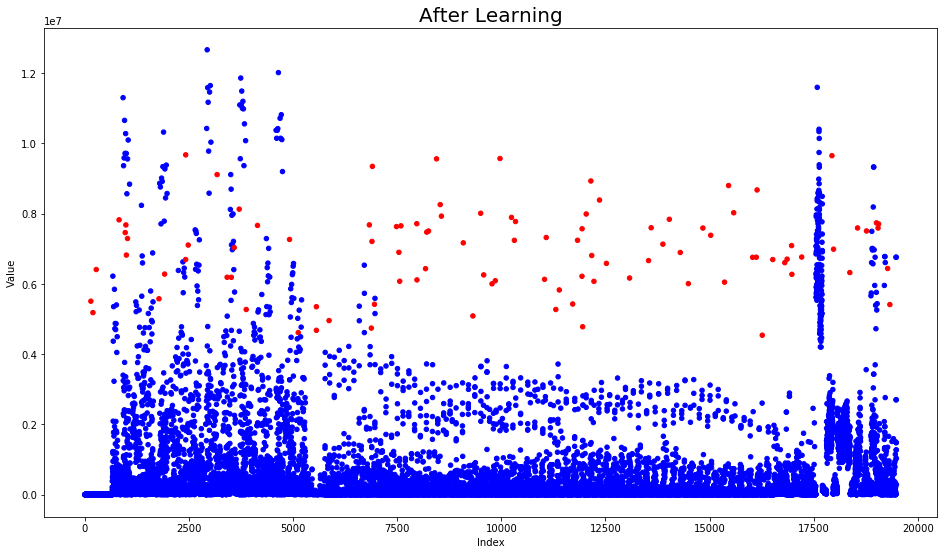

In [121]:

plt.figure(figsize=(16,9))
plt.scatter(df_new.index, df_new['trade_value'], c=[use_colours[x] for x in df_new["Actual"]], s=20)
plt.xlabel('Index')
plt.ylabel('Value')
plt.title("After Learning", fontsize="20")

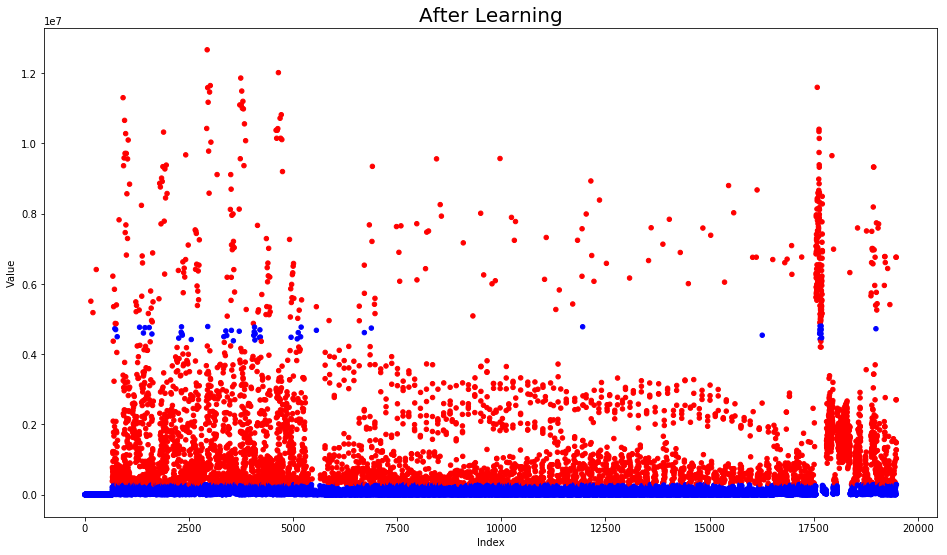

In [94]:

plt.figure(figsize=(16,9))
plt.scatter(df_new.index, df_new['trade_value'], c=[use_colours[x] for x in results_mad_AE], s=20)
plt.xlabel('Index')
plt.ylabel('Value')
plt.title("After Learning", fontsize="20")

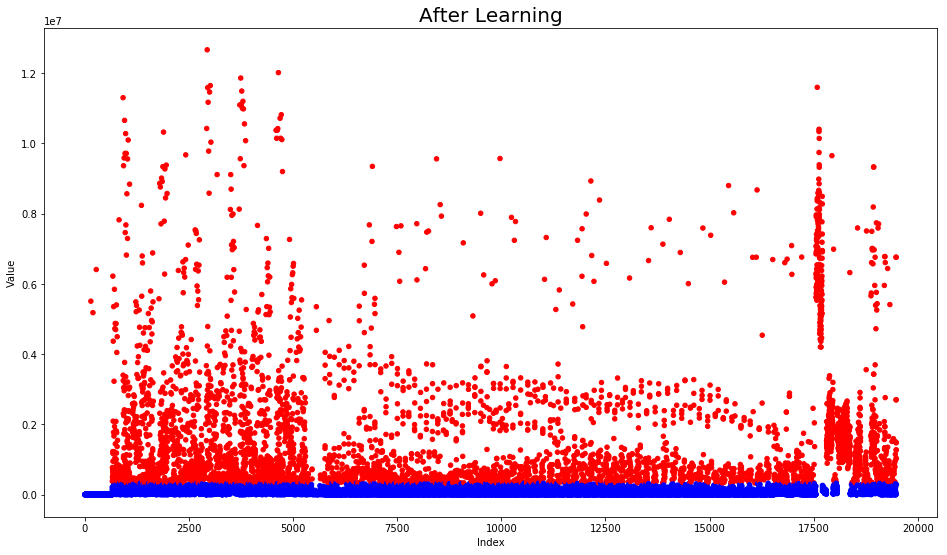

In [96]:

plt.figure(figsize=(16,9))
plt.scatter(df_new.index, df_new['trade_value'], c=[use_colours[x] for x in results_mad_Normal], s=20)
plt.xlabel('Index')
plt.ylabel('Value')
plt.title("After Learning", fontsize="20")

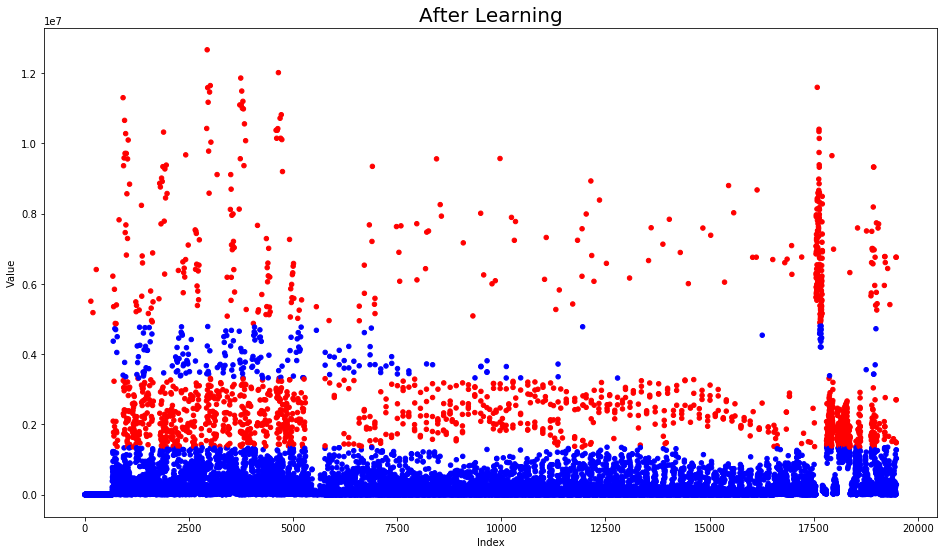

In [97]:

plt.figure(figsize=(16,9))
plt.scatter(df_new.index, df_new['trade_value'], c=[use_colours[x] for x in results_doublemad_AE], s=20)
plt.xlabel('Index')
plt.ylabel('Value')
plt.title("After Learning", fontsize="20")

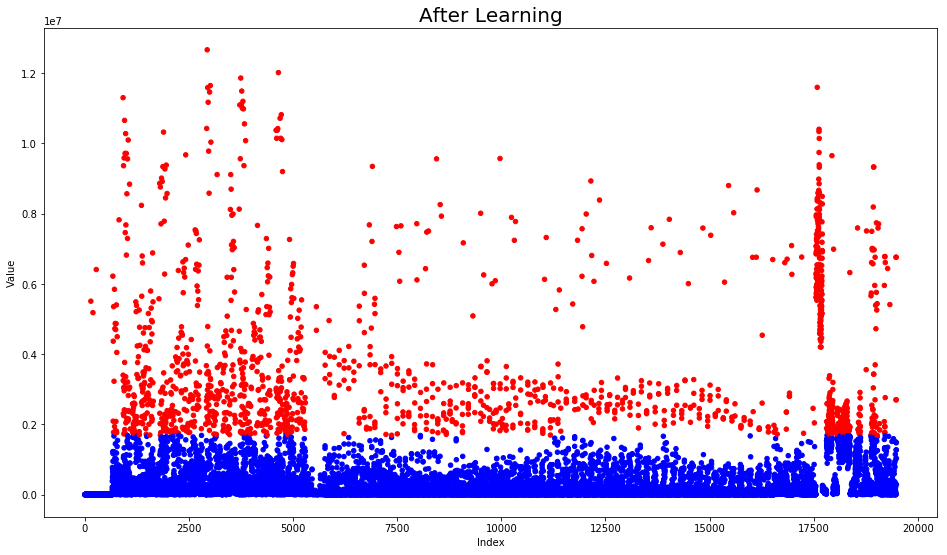

In [98]:

plt.figure(figsize=(16,9))
plt.scatter(df_new.index, df_new['trade_value'], c=[use_colours[x] for x in results_doublemad_Normal], s=20)
plt.xlabel('Index')
plt.ylabel('Value')
plt.title("After Learning", fontsize="20")

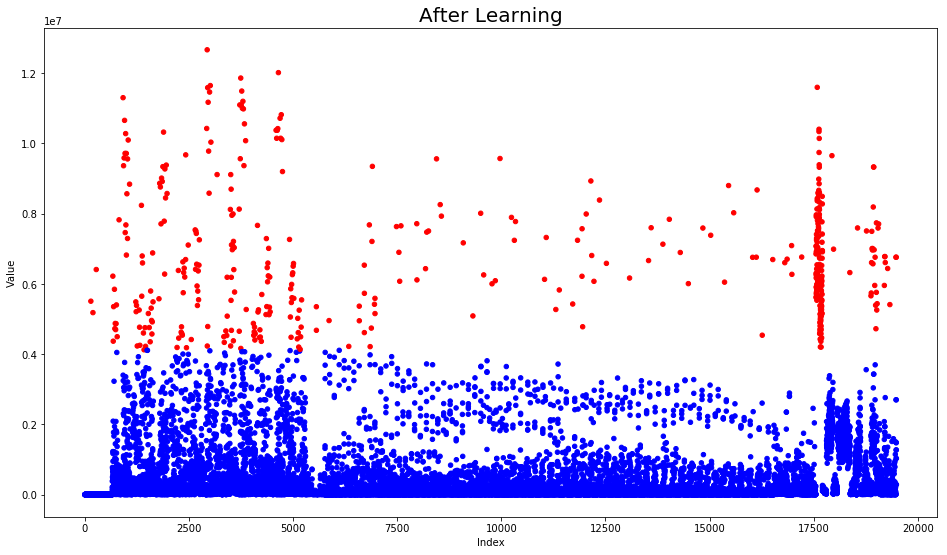

In [99]:

plt.figure(figsize=(16,9))
plt.scatter(df_new.index, df_new['trade_value'], c=[use_colours[x] for x in results_AD], s=20)
plt.xlabel('Index')
plt.ylabel('Value')
plt.title("After Learning", fontsize="20")

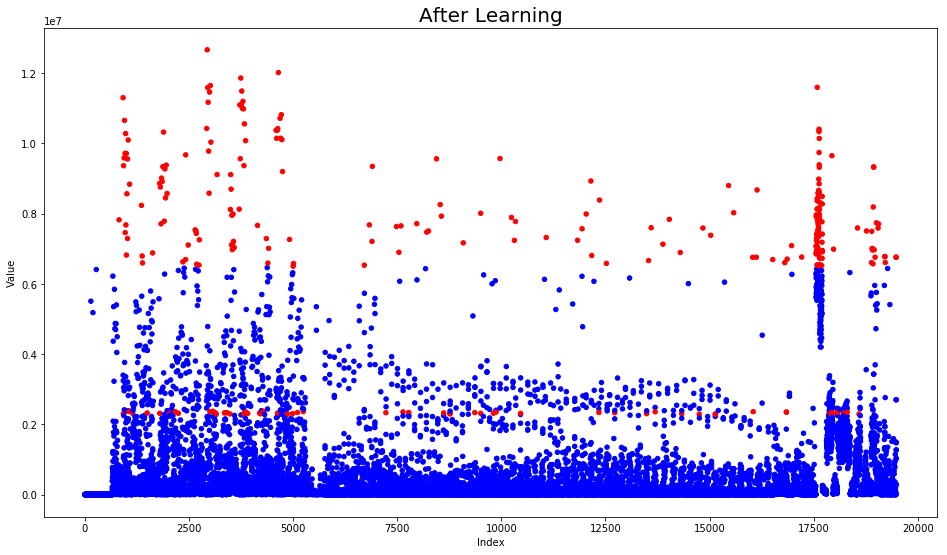

In [100]:

plt.figure(figsize=(16,9))
plt.scatter(df_new.index, df_new['trade_value'], c=[use_colours[x] for x in results_AD_AE], s=20)
plt.xlabel('Index')
plt.ylabel('Value')
plt.title("After Learning", fontsize="20")

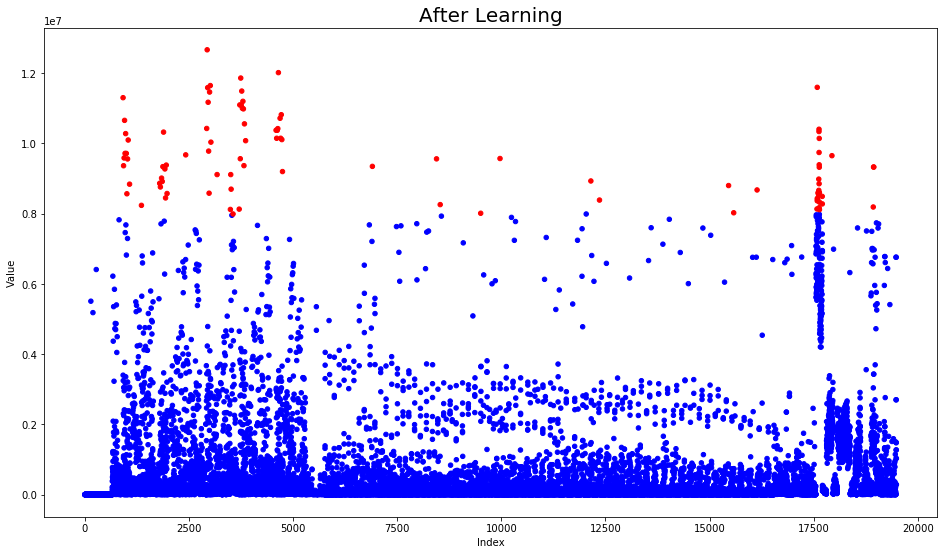

In [101]:

plt.figure(figsize=(16,9))
plt.scatter(df_new.index, df_new['trade_value'], c=[use_colours[x] for x in results_per], s=20)
plt.xlabel('Index')
plt.ylabel('Value')
plt.title("After Learning", fontsize="20")

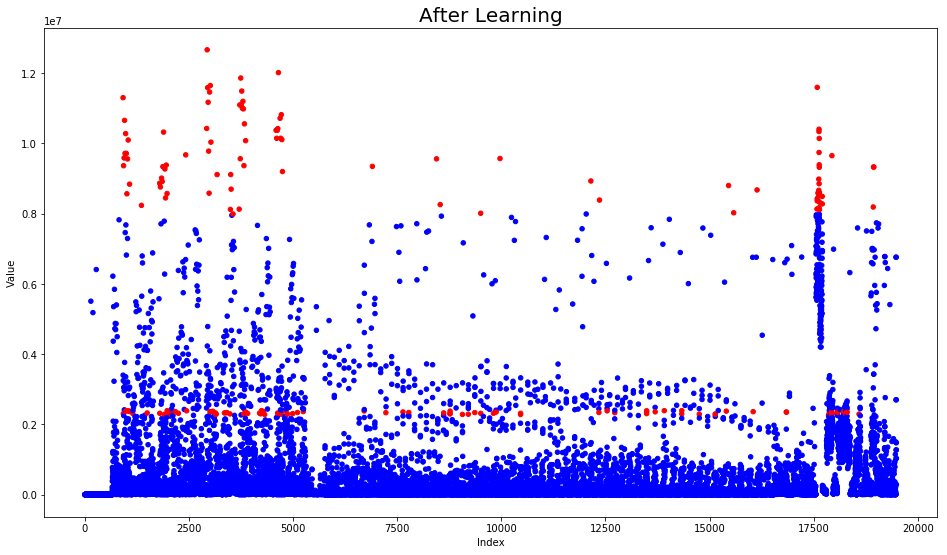

In [103]:

plt.figure(figsize=(16,9))
plt.scatter(df_new.index, df_new['trade_value'], c=[use_colours[x] for x in results_per_AE], s=20)
plt.xlabel('Index')
plt.ylabel('Value')
plt.title("After Learning", fontsize="20")

In [104]:
df_new["Outlier_MAD_AE"] = results_mad_AE
df_new["Outlier_MAD_Normal"] = results_mad_Normal 
df_new["Outlier_PER"] = results_per
df_new["Outlier_PER_AE"] = results_per_AE
df_new["Outlier_DoubleMAD_AE"] = results_doublemad_AE
df_new["Outlier_DoubleMAD_Normal"] = results_doublemad_Normal
df_new["Outlier_AD"] = results_AD
df_new["Outlier_AD_AE"] = results_AD_AE

In [105]:
df_new.head()

,id,flow_desc,reporter,partner,unit_weight,product_code,product_desc,trade_weight,trade_value,source,...,naivedist,dist,Outlier_MAD_AE,Outlier_MAD_Normal,Outlier_PER,Outlier_PER_AE,Outlier_DoubleMAD_AE,Outlier_DoubleMAD_Normal,Outlier_AD,Outlier_AD_AE
0,48491112,export,69,CHINA TAIWAN,kg,205000000,H/A/M/H-MT/FCF,0.0,0.0,usda_trade_flow_pig,...,65.873199,0.184004,False,False,False,False,False,False,False,False
1,48491111,export,69,CHINA TAIWAN,kg,205000000,H/A/M/H-MT/FCF,0.0,0.0,usda_trade_flow_pig,...,0.000000,0.184004,False,False,False,False,False,False,False,False
2,48491110,export,69,CHINA TAIWAN,kg,205000000,H/A/M/H-MT/FCF,0.0,0.0,usda_trade_flow_pig,...,0.000000,0.184004,False,False,False,False,False,False,False,False
3,48491109,export,69,CHINA TAIWAN,kg,205000000,H/A/M/H-MT/FCF,0.0,0.0,usda_trade_flow_pig,...,0.000000,0.184004,False,False,False,False,False,False,False,False
4,48491108,export,69,CHINA TAIWAN,kg,205000000,H/A/M/H-MT/FCF,0.0,0.0,usda_trade_flow_pig,...,0.000000,0.184004,False,False,False,False,False,False,False,False


In [106]:
cm=confusion_matrix(df_new.Actual,df_new.Outlier_MAD_AE)
print("Accuracy of MAD based Outlier detection using Autoencoders is :"+str(float(cm[0][0]+cm[1][1])/((cm[0][0]+cm[1][1])+cm[0][1]+cm[1][0])))
print("Precision of MAD based Outlier detection using Autoencoders is :"+str(float(cm[1][1])/(cm[1][1]+cm[1][0])))
print("Cohen's Kappa: "+str(cohen_kappa_score(df_new.Actual,df_new.Outlier_MAD_AE)))

Accuracy of MAD based Outlier detection using Autoencoders is :0.743854246857
Precision of MAD based Outlier detection using Autoencoders is :0.949494949495
Cohen's Kappa: 0.0265981429225


In [107]:
cm=confusion_matrix(df_new.Actual,df_new.Outlier_DoubleMAD_AE)
print("Accuracy of MAD based Outlier detection using Autoencoders is :"+str(float(cm[0][0]+cm[1][1])/((cm[0][0]+cm[1][1])+cm[0][1]+cm[1][0])))
print("Precision of MAD based Outlier detection using Autoencoders is :"+str(float(cm[1][1])/(cm[1][1]+cm[1][0])))
print("Cohen's Kappa: "+str(cohen_kappa_score(df_new.Actual,df_new.Outlier_DoubleMAD_AE)))

Accuracy of MAD based Outlier detection using Autoencoders is :0.913266615345
Precision of MAD based Outlier detection using Autoencoders is :0.949494949495
Cohen's Kappa: 0.0913599415109


In [108]:
cm=confusion_matrix(df_new.Actual,df_new.Outlier_AD_AE)
print("Accuracy of MAD based Outlier detection using Autoencoders is :"+str(float(cm[0][0]+cm[1][1])/((cm[0][0]+cm[1][1])+cm[0][1]+cm[1][0])))
print("Precision of MAD based Outlier detection using Autoencoders is :"+str(float(cm[1][1])/(cm[1][1]+cm[1][0])))
print("Cohen's Kappa: "+str(cohen_kappa_score(df_new.Actual,df_new.Outlier_AD_AE)))

Accuracy of MAD based Outlier detection using Autoencoders is :0.98588657942
Precision of MAD based Outlier detection using Autoencoders is :0.636363636364
Cohen's Kappa: 0.308925725548


In [109]:
cm=confusion_matrix(df_new.Actual,df_new.Outlier_PER_AE)
print("Accuracy of MAD based Outlier detection using Autoencoders is :"+str(float(cm[0][0]+cm[1][1])/((cm[0][0]+cm[1][1])+cm[0][1]+cm[1][0])))
print("Precision of MAD based Outlier detection using Autoencoders is :"+str(float(cm[1][1])/(cm[1][1]+cm[1][0])))
print("Cohen's Kappa: "+str(cohen_kappa_score(df_new.Actual,df_new.Outlier_PER_AE)))

Accuracy of MAD based Outlier detection using Autoencoders is :0.986297151655
Precision of MAD based Outlier detection using Autoencoders is :0.141414141414
Cohen's Kappa: 0.0887630583751


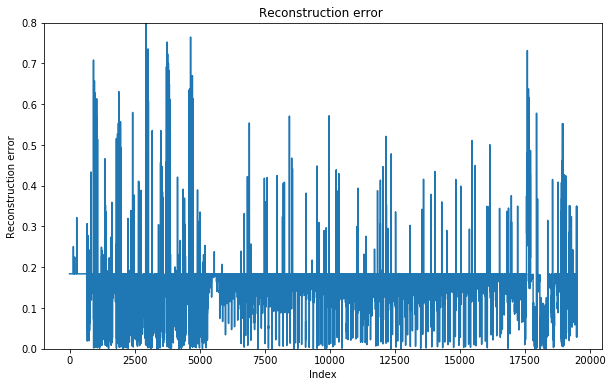

In [110]:
plt.figure(figsize=(10,6))
plt.plot(dist)
#plt.xlim((0,100))
plt.ylim((0,0.8))
plt.xlabel('Index')
plt.ylabel('Reconstruction error')
plt.title("Reconstruction error ")

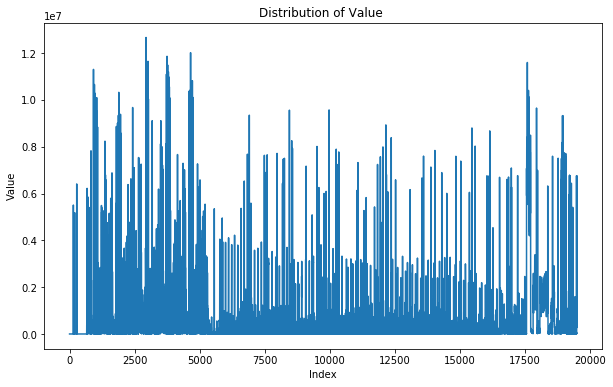

In [111]:
value = np.array(df_new["trade_value"])
plt.figure(figsize=(10,6))
plt.plot(value)

#plt.xlim((0,1000))
#plt.ylim((0,0.8))
plt.xlabel('Index')
plt.ylabel('Value')
plt.title("Distribution of Value ")

In [112]:
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
df_new_2 = df_new[["trade_value"]]
X_train,X_test = train_test_split(df_new_2,test_size=0.2)
X_test = X_test.reset_index(drop=True)
X_test["Actual"] = False
for i in Outliers:
    loc = np.random.randint(0, len(X_test))
    #print(X_test.loc[loc,"price"])
    X_test.loc[loc,"trade_value"] = i
    #print(X_test.loc[loc,"price"])
    X_test.loc[loc,"Actual"] = True
    #print(X_test.loc[loc,"Actual"])
X_test_sub = X_test[['trade_value']]
#print(X_test)
# fit the model
clf = IsolationForest(max_samples="auto",n_estimators=100,bootstrap=True,contamination=0.01,)
clf.fit(X_train)
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test_sub)

In [113]:
y_pred_test[y_pred_test ==1] = False
y_pred_test[y_pred_test ==-1] = True


In [114]:
from sklearn.metrics import confusion_matrix,roc_curve,auc,cohen_kappa_score
cm=confusion_matrix(X_test.Actual,y_pred_test)

In [115]:
cm

array([[3748,   50],
       [  42,   57]])

In [116]:
coh = cohen_kappa_score(X_test.Actual,y_pred_test)
print(coh)

0.541292432408


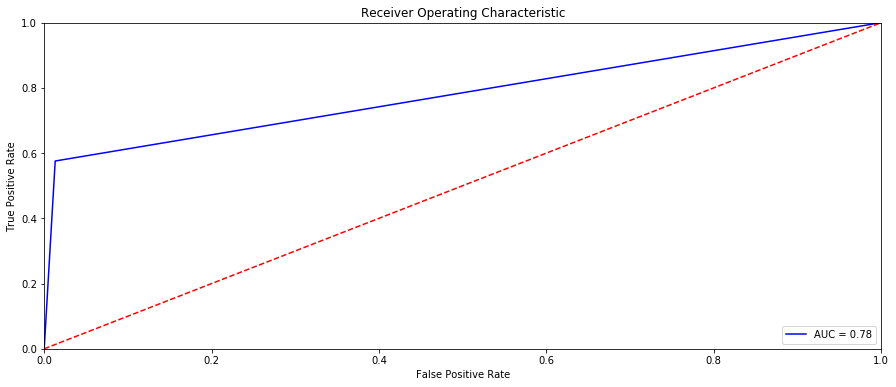

In [117]:
fpr, tpr, threshold = roc_curve(X_test.Actual,y_pred_test)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [118]:
print("Accuracy of Isolation Forest :"+str(float(cm[0][0]+cm[1][1])/((cm[0][0]+cm[1][1])+cm[0][1]+cm[1][0])))
print("Precision of Isolation Forest:"+str(float(cm[1][1])/(cm[1][1]+cm[1][0])))

Accuracy of Isolation Forest :0.976392096484
Precision of Isolation Forest:0.575757575758


In [119]:
X_test_sub.reset_index()
X_test_sub = X_test_sub.reset_index()
X_test_sub = X_test_sub.reset_index()
X_test_sub.columns.values[0] = "new_index"
X_test_sub["Actual"] = X_test["Actual"]

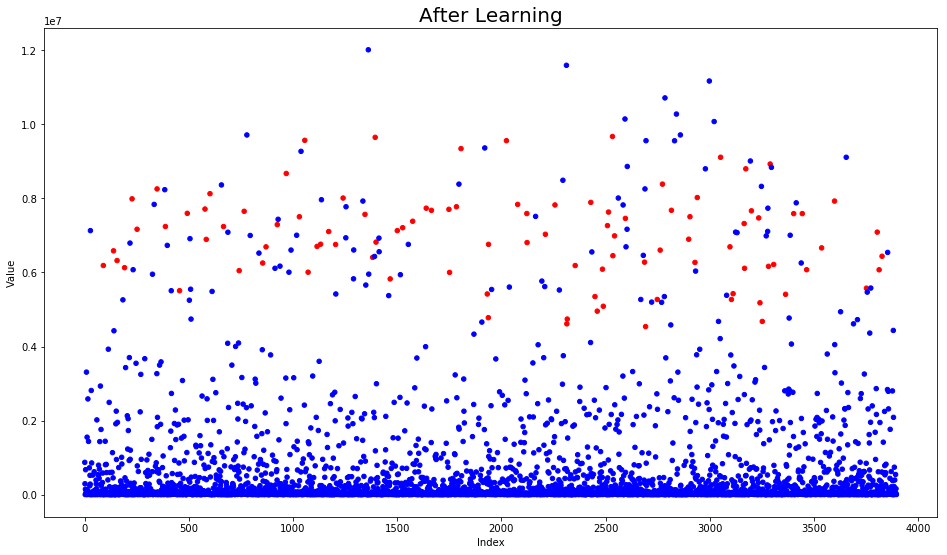

In [122]:
plt.figure(figsize=(16,9))
plt.scatter(X_test.index, X_test["trade_value"], c=[use_colours[x] for x in X_test["Actual"]], s=20)
plt.xlabel('Index')
plt.ylabel('Value')
plt.title("After Learning", fontsize="20")

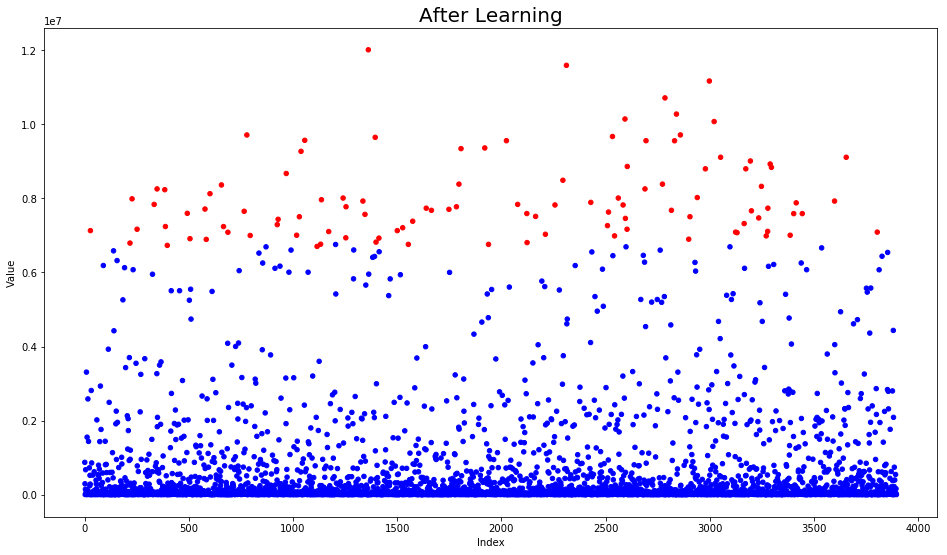

In [120]:
plt.figure(figsize=(16,9))
plt.scatter(X_test.index, X_test["trade_value"], c=[use_colours[x] for x in y_pred_test], s=20)
plt.xlabel('Index')
plt.ylabel('Value')
plt.title("After Learning", fontsize="20")